# A class to handle the reading in of data and batch generation for models

In [80]:
from __future__ import print_function
import json
import numpy as np
import random

In [76]:
class DataHandler(object):
    """Handler to read in data and generate data and batches for model training and evaluation"""
    def __init__(self, data_prefix, max_sequence_len=None):
        self._data_prefix = data_prefix
        
        self.read_data()
        if max_sequence_len:
            assert max_sequence_len >= self._max_seq_len, "Cannot for sequence length shorter than the data yields"
            self._max_seq_len = max_sequence_len
            
    def read_data(self):
        print("Creating Data objects...")
        # read in sdp data
        data = []
        with open(self._data_prefix, 'r') as f:
            for line in f:
                data.append(json.loads(line))
        self._paths = [ datum['path'] for datum in data ]
        self._max_seq_len = max([ len(path) for path in self._paths ])
        self._targets = [ datum['target'][0] for datum in data] # targets get doubly wrapped in lists
        
        #make sure all of the paths have same depth and all the targets have depth 2
#         print(self._paths)
#         print([target for target in self._targets])
        assert len(set(len(p) for path in self._paths for p in path)) == 1, "Not all path tuples have same len"
        assert set(len(target) for target in self._targets) == set([2]), "All target tuples must be pairs"
        
        # read in vocab and distribution
        vocab_and_dist = []
        with open(self._data_prefix+"_vocab", 'r') as f:
            for line in f:
                vocab_and_dist.append(json.loads(line))
        self._vocab = [x[0] for x in vocab_and_dist]
        self._true_vocab_dist = [x[1] for x in vocab_and_dist]
        self._vocab_dist = self._true_vocab_dist
        self._vocab2int = {v:i for (i,v) in enumerate(self._vocab)}
        self._int2vocab = {i:v for (v,i) in self._vocab2int.items()}
        
        # read in dependency vocab and distribution
        dep_and_dist = []
        with open(self._data_prefix+"_dep", 'r') as f:
            for line in f:
                dep_and_dist.append(json.loads(line))
        self._dep_vocab = [x[0] for x in dep_and_dist]
        self._true_dep_dist = [x[1] for x in dep_and_dist]
        self._dep_dist = self._true_dep_dist
        self._dep2int = {v:i for (i,v) in enumerate(self._dep_vocab)}
        self._int2dep = {i:v for (v,i) in self._dep2int.items()}
        print("Done creating Data objects")
    
    def _sequences_to_tensor(self, list_of_lists):
        """ Convert list of lists of either single elements or tuples into matrix of appropriate dim"""
        lengths = np.array([len(list_) for list_ in list_of_lists]).reshape([-1, 1])
        
        #matrix case
        if isinstance(list_of_lists[0][0], (int, float)):
            matrix = np.zeros([len(list_of_lists), self._max_seq_len])
            for i, list_ in enumerate(list_of_lists):
                matrix[i, :len(list_)] = list_
            return matrix, lengths
        
        #tensor case
        if isinstance(list_of_lists[0][0], (tuple, list)):
            k = len(list_of_lists[0][0]) # we asserted before that all of them were the same len
            tensor = np.zeros([len(list_of_lists), self._max_seq_len, k])
            for i, list_ in enumerate(list_of_lists):
                for j in range(k):
                    tensor[i, :len(list_), j] = [ x[j] for x in list_ ]
            return tensor, lengths
    
    def _generate_batch(self, offset, batch_size, neg_per=None):
        """Expects the data as list of lists of indices

        Converts them to matrices of indices, lang model labels, and lengths"""
        start = offset*batch_size
        end = start + batch_size
        if end > len(self._paths):
            end = len(self._paths)
#             print("Not full batch")
        inputs = self._paths[start:end]
        targets = np.array(self._targets[start:end])
        print(targets.shape)
        labels = np.ones(targets.shape[0]).reshape((-1, 1))
        input_mat, len_vec = self._sequences_to_tensor(inputs)
        # generate the negative samples
        # randomly choose one index for each negative sample 
        # TODO: option to replace more than one phrase element
        # and replace that with a random word drawn from the scaled unigram distribution
        if neg_per:
            negatives = []
            neg_targets = []
            for i, seq in enumerate(inputs):
                for neg in range(neg_per):
                    rand_idx = int(random.uniform(0, len(seq)))
                    sample = self._sample_distribution(self._vocab_dist)
#                     print(rand_idx)
                    neg_seq = seq[:]
#                     print(neg_seq)
                    neg_seq[rand_idx][0] = sample
                    negatives.append(neg_seq)
                    neg_targets.append(targets[i])
            neg_mat, neg_len = self._sequences_to_tensor(negatives)
            neg_labels = np.zeros_like(neg_len)
            print(labels.shape, neg_labels.shape)
            all_inputs = np.vstack((input_mat, neg_mat)).astype(np.int32)
            all_targets = np.vstack((targets, np.array(neg_targets))).astype(np.int32)
            all_labels = np.vstack((labels, neg_labels)).astype(np.int32)
            all_lengths = np.vstack((len_vec, neg_len)).astype(np.int32)
        else:
            all_inputs = input_mat.astype(np.int32)
            all_targets = targets.astype(np.int32)
            all_labels = labels.astype(np.int32)
            all_lengths = len_vec.astype(np.int32)
        return all_inputs, all_targets, all_labels, all_lengths
    
    def batches(self, batch_size, neg_per=5, offset=0):
        num_steps = len(self._paths) // batch_size
        for step in range(offset, num_steps):
            yield self._generate_batch(step, batch_size, neg_per=neg_per)
    
    def scale_vocab_dist(self, power):
        self._vocab_dist = self._distribution_to_power(self._true_vocab_dist, power)
        
    def scale_dep_dist(self, power):
        self._dep_dist = self._distribution_to_power(self._true_dep_dist, power)
        
    def _distribution_to_power(self, distribution, power):
        """Return a distribution, scaled to some power"""
        dist = [ pow(d, power) for d in distribution ]
        dist /= np.sum(dist)
        return dist
    
    def _sample_distribution(self, distribution):
        """Sample one element from a distribution assumed to be an array of normalized
        probabilities.
        """
        r = random.uniform(0, 1)
        s = 0
        for i in range(len(distribution)):
            s += distribution[i]
            if s >= r:
                return i
        return len(distribution) - 1
    
    @property
    def data_prefix(self):
        return self._data_prefix
    
    @property
    def vocab(self):
        return self._vocab
    
    @property
    def dep_vocab(self):
        return self._dep_vocab

In [77]:
data_handler = DataHandler('data/wiki_sdp_100')

Creating Data objects...
Done creating Data objects


In [100]:
data_handler.scale_vocab_dist(1.5)
print(data_handler._vocab_dist)

[  2.11760549e-01   1.54333178e-01   1.25144722e-01   8.95462737e-02
   7.01739473e-02   6.25782425e-02   4.03236025e-02   3.28540053e-02
   1.75573183e-02   1.38039791e-02   9.55699360e-03   8.77174342e-03
   8.77174342e-03   7.27025136e-03   7.27025136e-03   6.55548142e-03
   6.55548142e-03   5.86580425e-03   5.20216840e-03   5.20216840e-03
   5.20216840e-03   5.20216840e-03   4.56563896e-03   3.95742358e-03
   3.95742358e-03   3.37890749e-03   3.37890749e-03   3.37890749e-03
   3.37890749e-03   3.37890749e-03   3.37890749e-03   2.83170181e-03
   2.83170181e-03   2.83170181e-03   2.83170181e-03   2.83170181e-03
   2.83170181e-03   2.83170181e-03   2.83170181e-03   2.83170181e-03
   2.31771268e-03   2.31771268e-03   2.31771268e-03   2.31771268e-03
   2.31771268e-03   1.83924428e-03   1.83924428e-03   1.83924428e-03
   1.83924428e-03   1.83924428e-03   1.83924428e-03   1.83924428e-03
   1.83924428e-03   1.83924428e-03   1.39916053e-03   1.39916053e-03
   1.39916053e-03   1.39916053e-03

(0, 0.25)

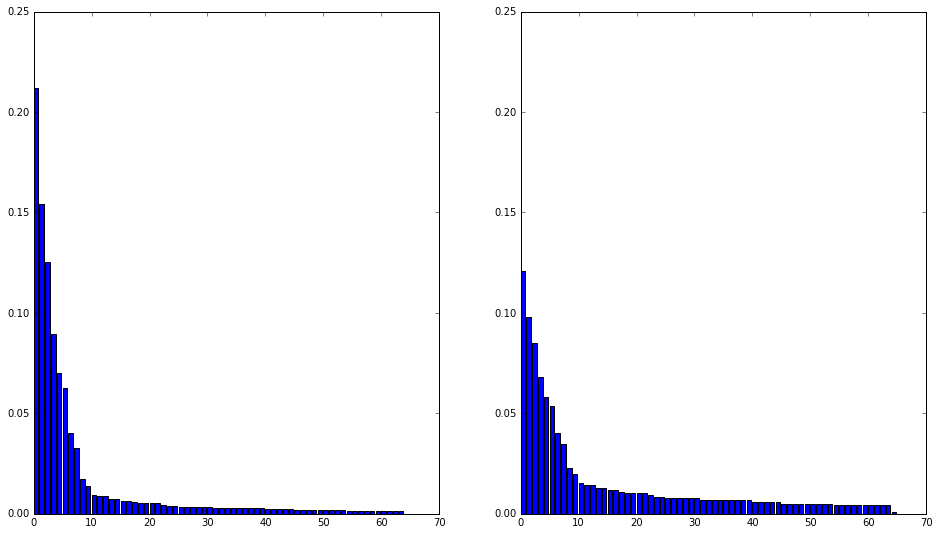

In [101]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(16,9))
ax0.bar(range(len(data_handler._vocab_dist)), data_handler._vocab_dist)
ax1.bar(range(len(data_handler._true_vocab_dist)), data_handler._true_vocab_dist)
ax0.set_ylim(0, .25)
ax1.set_ylim(0, .25)

In [78]:
for batch in data_handler.batches(100):
    print([ t.shape for t in batch])

(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (600, 1)]
(100, 2)
(100, 1) (500, 1)
[(600, 16, 2), (600, 2), (600, 1), (6

In [5]:
%%bash
git pull

Updating 60f4fb2..865390d
Fast-forward
 wiki2sdp.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


From github.com:teffland/Relation-Extraction
   60f4fb2..865390d  master     -> origin/master


In [6]:
%%bash
python wiki2sdp.py -n 50000 -m 3;

Analyzing 50000 sentences
(0:0:0) Reading Data...
(0:1:22) Creating vocab...
(0:1:24) Writing data...
(0:3:54) Writing vocab...
DONE: Created 549566 SDPs from 50000 sentences with a total vocab size of 22265
Took a total of 0:3:54 hours


In [ ]:
%%bash
tensorboard --port=6007 --logdir=tensor_summaries/drnn_wiki_w2v;

In [9]:
%%bash
ls tensor_summaries

drnn_embed_test1
drnn_embed_wiki1
drnn_embed_wiki_easy
drnn_wiki_w2v
